In [44]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5


In [45]:
def compile_data(data_path):
    main_df = pd.DataFrame()
    
    for directory, dirnames, filenames in os.walk(data_path):
        for count, filename in enumerate(filenames):
            ticker = filename[:-4]
            df = pd.read_csv('{}/{}.csv'.format(data_path, ticker))
            df.set_index('dt', inplace=True)

            df.rename(columns={'close': ticker}, inplace=True)
            df.drop(['open', 'high', 'low', 'volume'], 1, inplace=True)

            if main_df.empty:
                main_df = df
            else:
                main_df = main_df.join(df, how='outer')

            if count % 100 == 0:
                print(count)
    print(main_df.head())
    main_df.to_csv('df_joined_closes.csv')
    
data_path = "./Trial-assignment/data/market_data"
compile_data(data_path)

0
100
200
300
400
500
600
                       BNI     TMK    DLTR    BXP   EXPD      NBL      FHN  \
dt                                                                           
2010-01-04 09:45:00  98.72  44.050  48.790  67.96  35.00  73.2400  13.4950   
2010-01-04 10:00:00  98.75  43.890  48.885  67.55  34.95  73.5525  13.4900   
2010-01-04 10:15:00  98.75  43.990  48.680  66.82  34.90  73.4900  13.4099   
2010-01-04 10:30:00  98.78  44.110  48.450  67.21  35.00  73.5700  13.4250   
2010-01-04 10:45:00  98.77  44.145  48.470  67.70  35.00  73.4300  13.4300   

                        PKI      ISRG  TRIP  ...     MMC      FOX     CINF  \
dt                                           ...                             
2010-01-04 09:45:00  20.570  308.0900   NaN  ...   22.15  16.2701  26.4500   
2010-01-04 10:00:00  20.470  307.9000   NaN  ...   22.14  16.3000  26.4799   
2010-01-04 10:15:00  20.475  307.7915   NaN  ...   22.08  16.3200  26.4800   
2010-01-04 10:30:00  20.369  308.0199

In [46]:
main_df = pd.read_csv('df_joined_closes.csv')
main_df.set_index('dt', inplace=True)
columns_to_del = main_df.tail().isnull().any()
main_df.drop(main_df.columns[columns_to_del], axis=1, inplace=True)
main_df.fillna(0., inplace=True)
start_train = '2016-01-01'
end_train = '2017-12-31'
main_df = main_df[start_train:end_train]

In [47]:
def share_data_by_sectors(df):
    data = dict()
    sectors_df = pd.read_csv("./Trial-assignment/data/sectors.csv") 
    sectors = sectors_df['INDUSTRY_GROUP'].unique()
    for sector in sectors:
        tickers = sectors_df[sectors_df['INDUSTRY_GROUP'] == sector]['TICKER'].unique()
        tickers = set(tickers) & set(df.columns)
        tickers = list(tickers)
        if len(tickers) > 1:
            data[sector] = df[tickers]
    return data

data = share_data_by_sectors(main_df)

In [48]:
def find_cointegrated_pairs(data, significance=0.05):  
    n = data.shape[1]  
    c = n*(n-1)/2
    score_matrix = np.zeros((n, n))  
    pvalue_matrix = np.ones((n, n))  
    keys = data.keys()  
    pairs = []  
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]  
            S2 = data[keys[j]]  
            result = coint(S1, S2)  
            score = result[0]  
            pvalue = result[1]  
            score_matrix[i, j] = score  
            pvalue_matrix[i, j] = pvalue  
            if pvalue < significance / c:  
#                 print((keys[i], keys[j]))
                pairs.append((keys[i], keys[j])) 
    return score_matrix, pvalue_matrix, pairs  

In [49]:
%%time
pairs_dict = dict()
pairs_list = []
for sector, df in data.items():
    scores, pvalues, pairs = find_cointegrated_pairs(df)
    pairs_dict[sector] = pairs
    pairs_list.extend(pairs)

CPU times: user 10min 37s, sys: 6min 52s, total: 17min 30s
Wall time: 4min 36s


In [50]:
len(pairs_list)

653

In [7]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def count_intersections_with_level(series, level=0.):
    series = series - level
    return np.count_nonzero(series.apply(np.sign).diff())

def get_spread_info(prices_df, ticker_1, ticker_2):
    S1 = prices_df[ticker_1]
    S2 = prices_df[ticker_2]
    score, coint_pvalue, _ = coint(S1, S2)
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[ticker_1]
    b = results.params[ticker_1]
    spread = S2 - b * S1
    result = adfuller(spread)
    adfuller_pvalue = result[1]
    z_score = zscore(spread)
    zero_intersections_cnt = count_intersections_with_level(z_score)
    one_intersections_cnt = count_intersections_with_level(z_score, 1.)
    m_one_intersections_cnt = count_intersections_with_level(z_score, -1.)
    corr = np.corrcoef(S1, S2)[1][0]
    return coint_pvalue, adfuller_pvalue, zero_intersections_cnt, one_intersections_cnt, m_one_intersections_cnt, corr


In [8]:
start = '2017-01-01'
recent_df = main_df[start:]
def apply_spread_info_to_df(x):
    coint_pvalue, adfuller_pvalue, zero_intersections_cnt, \
    one_intersections_cnt, m_one_intersections_cnt, corr = \
        get_spread_info(recent_df, x['ticker_1'], x['ticker_2'])
    x['coint_pvalue'] = coint_pvalue
    x['adfuller_pvalue'] = adfuller_pvalue
    x['zero_intersections_cnt'] = zero_intersections_cnt
    x['one_intersections_cnt'] = one_intersections_cnt
    x['m_one_intersections_cnt'] = m_one_intersections_cnt
    x['corr'] = corr
    return x

In [9]:
%%time
pairs_df = pd.DataFrame(pairs_list, columns=['ticker_1', 'ticker_2'])
pairs_df = pairs_df.apply(apply_spread_info_to_df, axis=1)

CPU times: user 5min 39s, sys: 5min 2s, total: 10min 42s
Wall time: 2min 59s


In [114]:
pairs_df = pairs_df[pairs_df['adfuller_pvalue'] < 0.05]
pairs_df = pairs_df[pairs_df['coint_pvalue'] < 0.05]
pairs_df = pairs_df[pairs_df['corr'] > 0.8]
pairs_df = pairs_df[abs((pairs_df['m_one_intersections_cnt'] - pairs_df['one_intersections_cnt']) / pairs_df['m_one_intersections_cnt']) < 0.1]
pairs_df = pairs_df[pairs_df['one_intersections_cnt'] / pairs_df['zero_intersections_cnt'] > 0.5]

In [121]:
pairs_df.sort(['corr', 'adfuller_pvalue'], ascending=[False, True], inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [117]:
pairs_df.head(40)

,ticker_1,ticker_2,coint_pvalue,adfuller_pvalue,zero_intersections_cnt,one_intersections_cnt,m_one_intersections_cnt,corr
547,INTU,ADBE,1.587828e-04,0.004885,84,55,52,0.896351
61,PPG,SHW,2.159160e-07,0.007019,58,68,64,0.896004
71,EMN,VSM,1.053013e-07,0.000758,51,91,95,0.872065
133,CPB,KR,1.455297e-03,0.010723,59,49,49,0.864915
68,DWDP,ASIX,2.154879e-08,0.004253,86,75,79,0.848823
554,FISV,CDNS,9.625636e-07,0.020343,84,67,63,0.848731
641,SYK,ALGN,3.105096e-09,0.001037,23,27,29,0.848026
599,STI,MS,8.404530e-06,0.017575,50,61,65,0.816975
511,BXP,MAC,1.776721e-04,0.010846,115,68,75,0.816128


In [118]:
used_tickers = set()
used_tickers.add('GOOGL')
for index, row in pairs_df.head(40).iterrows():
    if (row['ticker_1'] not in used_tickers and 
        row['ticker_2'] not in used_tickers):
        print("(symbol('{}'), symbol('{}')),".format(row['ticker_1'], row['ticker_2']))
        used_tickers.add(row['ticker_1'])
        used_tickers.add(row['ticker_2'])

(symbol('INTU'), symbol('ADBE')),
(symbol('PPG'), symbol('SHW')),
(symbol('EMN'), symbol('VSM')),
(symbol('CPB'), symbol('KR')),
(symbol('DWDP'), symbol('ASIX')),
(symbol('FISV'), symbol('CDNS')),
(symbol('SYK'), symbol('ALGN')),
(symbol('STI'), symbol('MS')),
(symbol('BXP'), symbol('MAC')),


6.504740834264161e-06
3.2018096732112145e-05


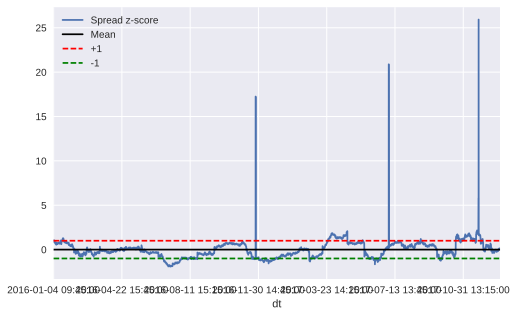

In [103]:
def show_spread(prices_df, ticker_1, ticker_2):
    S1 = prices_df[ticker_1]
    S2 = prices_df[ticker_2]
    score, pvalue, _ = coint(S1, S2)
    print(pvalue)
    S1 = sm.add_constant(S1)
    results = sm.OLS(S2, S1).fit()
    S1 = S1[ticker_1]
    b = results.params[ticker_1]
    spread = S2 - b * S1
    result = adfuller(spread)
    print(result[1])
    zscore(spread).plot()
    plt.axhline(zscore(spread).mean(), color='black')
    plt.axhline(1.0, color='red', linestyle='--')
    plt.axhline(-1.0, color='green', linestyle='--')
    plt.legend(['Spread z-score', 'Mean', '+1', '-1']);
    
show_spread(main_df, 'INTU', 'ADBE')

In [ ]:
# Бэктестинг алгоритма https://www.quantopian.com
import numpy as np
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import adfuller

import quantopian.optimize as opt
import quantopian.algorithm as algo

def initialize(context):
    # Quantopian backtester specific variables
    set_slippage(slippage.FixedSlippage(spread=0))
    set_commission(commission.PerTrade(cost=1))
    set_symbol_lookup_date('2018-01-01')
    
    context.stock_pairs = [
        (symbol('INTU'), symbol('ADBE')),
        (symbol('PPG'), symbol('SHW')),
        (symbol('EMN'), symbol('VSM')),
        (symbol('CPB'), symbol('KR')),
        # (symbol('DWDP'), symbol('ASIX')),  # not enough data
        (symbol('FISV'), symbol('CDNS')),
        (symbol('SYK'), symbol('ALGN')),
        (symbol('STI'), symbol('MS')),
        (symbol('BXP'), symbol('MAC')),
    ]
    
    context.stocks = []
    for sp in context.stock_pairs:
       context.stocks.extend(sp)
    
    context.num_pairs = len(context.stock_pairs)
    # strategy specific variables
    context.regression_window = 20 # used for regression
    context.z_window = 20 # used for zscore calculation, must be <= lookback
    context.coint_window = 120
    context.hist_window = 120
    
    context.target_weights = pd.Series(index=context.stocks, data=0.25)
    
    context.spread = np.ndarray((context.num_pairs, context.hist_window))
    context.inLong = [False] * context.num_pairs
    context.inShort = [False] * context.num_pairs
    
    # Only do work 30 minutes before close
    schedule_function(func=check_pair_status, date_rule=date_rules.every_day(), time_rule=time_rules.market_close(minutes=30))
    
# Will be called on every trade event for the securities you specify. 
def handle_data(context, data):
    # Our work is now scheduled in check_pair_status
    pass

def check_pair_status(context, data):
    
    prices = data.history(context.stocks, 'price', context.hist_window, '1d')
    
    
    context.target_weights = get_current_portfolio_weights(context, data)
    
    for i in range(context.num_pairs):

        (stock_y, stock_x) = context.stock_pairs[i]

        Y = prices[stock_y]
        X = prices[stock_x]
        
        # Comment explaining try block
        try:
            hedge = hedge_ratio(
                Y.iloc[-context.regression_window::],
                X.iloc[-context.regression_window::],
                add_const=True)      
        except ValueError as e:
            log.debug(e)
            return

        
        context.spread[i, :] = Y - hedge * X
        
        if context.spread.shape[1] >= context.z_window:
            # Keep only the z-score lookback period
            spreads = context.spread[i, -context.z_window:]
            
            zscore = (spreads[-1] - spreads.mean()) / spreads.std()
            
            coint_spreads = context.spread[i,-context.coint_window:]
            result = adfuller(coint_spreads)
            pvalue = result[1]
            coint = pvalue < 0.05
            
            if not coint:
                context.target_weights[stock_y] = 0
                context.target_weights[stock_x] = 0
                
                context.inShort[i] = False
                context.inLong[i] = False
                

            elif context.inShort[i] and zscore < 0.0:
                context.target_weights[stock_y] = 0
                context.target_weights[stock_x] = 0
                
                context.inShort[i] = False
                context.inLong[i] = False
                

            elif context.inLong[i] and zscore > 0.0:
                context.target_weights[stock_y] = 0
                context.target_weights[stock_x] = 0
                
                context.inShort[i] = False
                context.inLong[i] = False

            elif zscore < -1.0 and (not context.inLong[i]):
                # Only trade if NOT already in a trade 
                y_target_shares = 1
                X_target_shares = -hedge
                context.inLong[i] = True
                context.inShort[i] = False

                (y_target_pct, x_target_pct) = computeHoldingsPct(y_target_shares,X_target_shares, Y[-1], X[-1])
                
                context.target_weights = rebalance_weights(
                    context.target_weights, stock_y, stock_x, 
                    y_target_pct, x_target_pct)       

            elif zscore > 1.0 and (not context.inShort[i]):
                # Only trade if NOT already in a trade
                y_target_shares = -1
                X_target_shares = hedge
                context.inShort[i] = True
                context.inLong[i] = False

                (y_target_pct, x_target_pct) = computeHoldingsPct( y_target_shares, X_target_shares, Y[-1], X[-1] )
                
                context.target_weights = rebalance_weights(
                    context.target_weights, stock_y, stock_x, 
                    y_target_pct, x_target_pct)

    allocate(context, data)    

def hedge_ratio(Y, X, add_const=True):
    if add_const:
        X = sm.add_constant(X)
        model = sm.OLS(Y, X).fit()
        return model.params[1]
    model = sm.OLS(Y, X).fit()
    return model.params.values
   
def computeHoldingsPct(yShares, xShares, yPrice, xPrice):
    yDol = yShares * yPrice
    xDol = xShares * xPrice
    notionalDol =  abs(yDol) + abs(xDol)
    y_target_pct = yDol / notionalDol
    x_target_pct = xDol / notionalDol
    return (y_target_pct, x_target_pct)

def get_current_portfolio_weights(context, data):  
    positions = context.portfolio.positions  
    positions_index = pd.Index(positions)  
    share_counts = pd.Series(  
        index=positions_index,  
        data=[positions[asset].amount for asset in positions]  
    )

    current_prices = data.current(positions_index, 'price')  
    current_weights = share_counts * current_prices / context.portfolio.portfolio_value  
    return current_weights.reindex(positions_index.union(context.stocks), fill_value=0.0)  

def get_holdings_cnt(target_weights):
    holdings_cnt = 0.
    for w in target_weights:
        if abs(w) > 0.:
            holdings_cnt += 1
    holdings_cnt /= 2.
    return holdings_cnt

def rebalance_weights(target_weights, stock_y, stock_x, y_target_pct, x_target_pct):
    holdings_cnt = get_holdings_cnt(target_weights)
    target_weights = target_weights * holdings_cnt
    target_weights[stock_y] = y_target_pct
    target_weights[stock_x] = x_target_pct
    holdings_cnt = get_holdings_cnt(target_weights)
    target_weights = target_weights / holdings_cnt
    return target_weights

def allocate(context, data):    
    # Set objective to match target weights as closely as possible, given constraints
    objective = opt.TargetWeights(context.target_weights)
    
    # Define constraints
    constraints = []
    constraints.append(opt.MaxGrossExposure(1.0))
    
    
    algo.order_optimal_portfolio(
        objective=objective,
        constraints=constraints,
    )

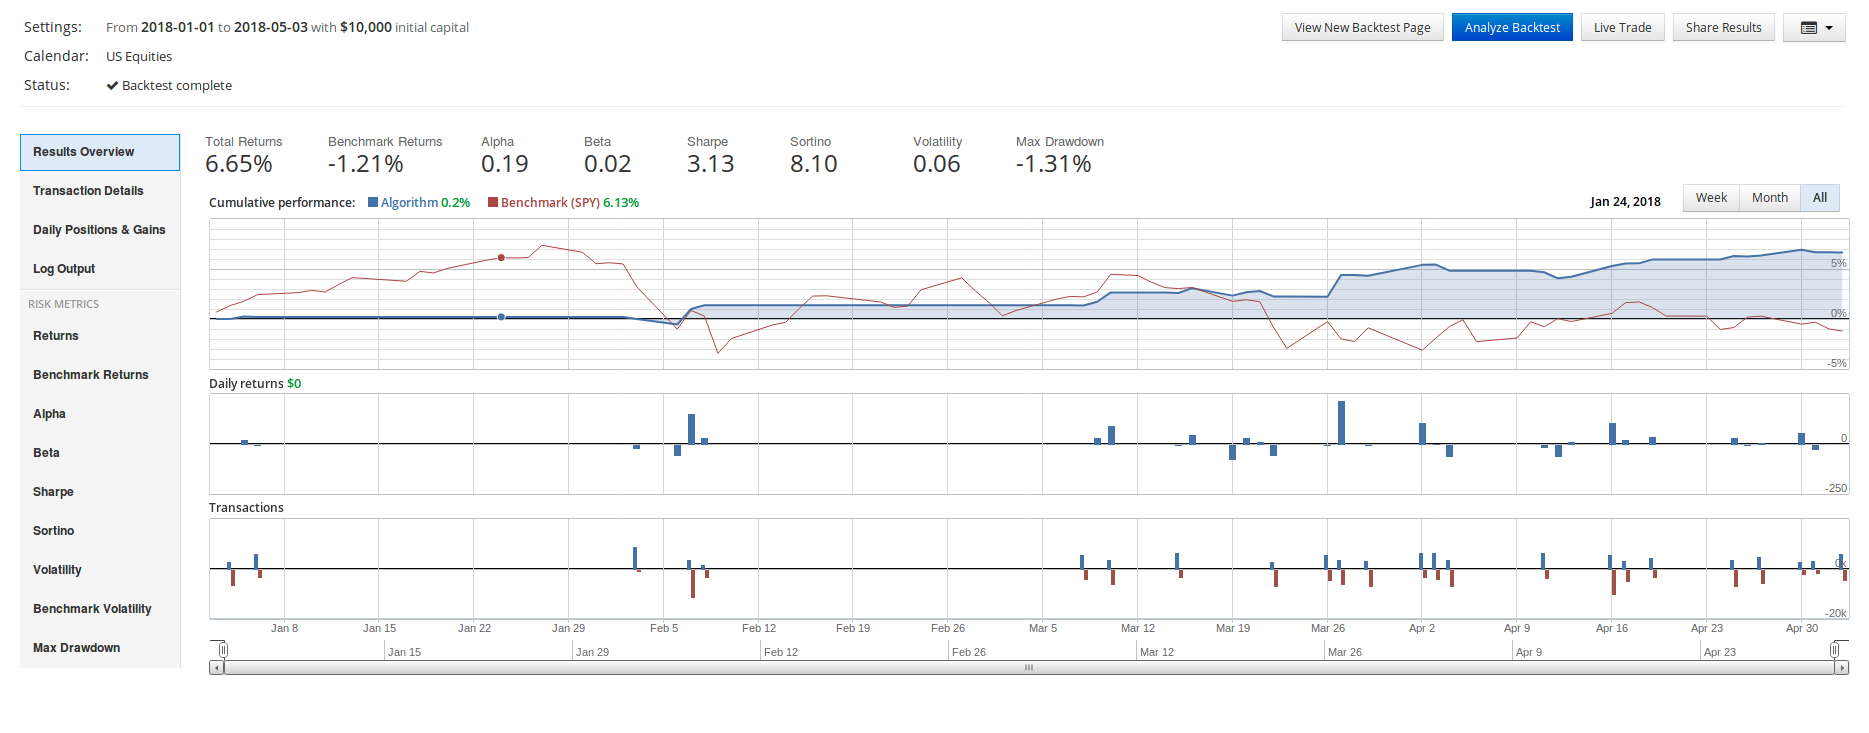

In [111]:
from IPython.display import Image
Image("./quantopian_backtest_result.png")